In [2]:
import re
import numpy as np
import pandas as pd
import tqdm.auto as tqdm
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, BatchNormalization


nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
def preprocess(text):
  text = text.lower()
  text = [word for word in text.split() if not word in all_stopwords and len(word)>1]
  text = re.sub('[^a-z ]', ' ', ' '.join(text))
  text = ' '.join(text.split())
  return text

In [14]:
def create_model(max_len, vocab_len, y):

  model = Sequential()
  model.add(Input(shape=(max_len,)))
  model.add(Embedding(vocab_len, 512, mask_zero=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(LSTM(256, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())
  model.add(LSTM(128))
  model.add(Dropout(0.2))
  model.add(Dense(units=128, activation='relu'))
  model.add(Dense(units=y.shape[1], activation='sigmoid'))

  return model

In [5]:
train = pd.read_csv('train.csv')
train.drop('ID', axis=1, inplace=True)
train.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [6]:
all_stopwords = stopwords.words('english')

In [7]:
train['MERGED'] = train.TITLE + ' ' + train.ABSTRACT

In [8]:
train['MERGED'] = train.MERGED.apply(preprocess)

In [9]:
train.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,MERGED
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,reconstructing subject specific effect maps pr...
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,rotation invariance neural network rotation in...
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,spherical polyharmonics poisson kernels polyha...
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,finite element approximation stochastic maxwel...
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,comparative study discrete wavelet transforms ...


In [10]:
train['MERGED'] = train.MERGED.apply(text_to_word_sequence)

(array([6.460e+02, 2.646e+03, 5.110e+03, 5.664e+03, 3.871e+03, 2.173e+03,
        7.910e+02, 6.200e+01, 7.000e+00, 2.000e+00]),
 array([  4. ,  33.2,  62.4,  91.6, 120.8, 150. , 179.2, 208.4, 237.6,
        266.8, 296. ]),
 <a list of 10 Patch objects>)

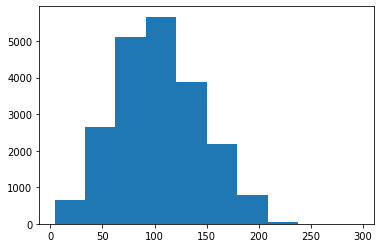

In [11]:
plt.hist([len(title) for title in train.MERGED])

In [12]:
len(train.loc[[len(title)<225 for title in train.MERGED]])

20948

In [15]:
train = train.loc[[len(title)<225 for title in train.MERGED]]

In [16]:
len({word for word_list in train.MERGED for word in word_list})

50656

In [17]:
max_len_merged = max([len(abstract) for abstract in train.MERGED])
vocab_len = len({word for word_list in train.MERGED for word in word_list})

In [18]:
print(max_len_merged)
print(vocab_len)

224
50656


In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train.MERGED)
train['MERGED'] = tokenizer.texts_to_sequences(train.MERGED)

In [20]:
train.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,MERGED
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,"[4490, 1104, 272, 167, 650, 983, 16, 790, 1104..."
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,"[1206, 2258, 45, 17, 1206, 2258, 1203, 2258, 1..."
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,"[1727, 19399, 1284, 1823, 14628, 78, 178, 285,..."
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,"[97, 980, 207, 140, 3529, 2312, 5597, 9686, 21..."
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,"[3158, 24, 332, 2976, 2827, 2976, 554, 882, 72..."


In [21]:
train.shape

(20948, 9)

In [22]:
X = pad_sequences(train.MERGED, maxlen=max_len_merged)

In [23]:
X.shape

(20948, 224)

In [24]:
train.head()

,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,MERGED
0,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,"[4490, 1104, 272, 167, 650, 983, 16, 790, 1104..."
1,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,"[1206, 2258, 45, 17, 1206, 2258, 1203, 2258, 1..."
2,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,"[1727, 19399, 1284, 1823, 14628, 78, 178, 285,..."
3,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,"[97, 980, 207, 140, 3529, 2312, 5597, 9686, 21..."
4,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,"[3158, 24, 332, 2976, 2827, 2976, 554, 882, 72..."


In [25]:
y = train.iloc[:, 2:-1]
y.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,0,0,0,0,0
1,1,0,0,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,1,0,0,1,0,0


In [28]:
model = create_model(max_len_merged, vocab_len, y)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [29]:
model.fit(X, y, batch_size=128, epochs=25)

Epoch 1/25
  1/164 [..............................] - ETA: 6:46 - loss: 0.7418 - accuracy: 0.1094WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0013s vs `on_train_batch_end` time: 0.0470s). Check your callbacks.


164/164 [==============================] - 12s 73ms/step - loss: 0.2863 - accuracy: 0.6904
Epoch 2/25
164/164 [==============================] - 8s 47ms/step - loss: 0.1823 - accuracy: 0.7748
Epoch 3/25
164/164 [==============================] - 8s 48ms/step - loss: 0.1361 - accuracy: 0.8091
Epoch 4/25
164/164 [==============================] - 8s 48ms/step - loss: 0.0938 - accuracy: 0.8312
Epoch 5/25
164/164 [==============================] - 8s 47ms/step - loss: 0.0600 - accuracy: 0.8508
Epoch 6/25
164/164 [==============================] - 8s 48ms/step - loss: 0.0393 - accuracy: 0.8554
Epoch 7/25
164/164 [==============================] - 8s 47ms/step - loss: 0.0260 - accuracy: 0.8692
Epoch 8/25
164/164 [==============================] - 8s 48ms/step - loss: 0.0180 - accuracy: 0.8788
Epoch 9/25
164/164 [==============================] - 8s 48ms/step - loss: 0.0142 - accuracy: 0.8698
Epoch 10/25
164/164 [==============================] - 8s 47ms/step - loss: 0.0110 - accuracy: 0.8797

This model was giving 79.08% accuracy on test dataset